In [362]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.stats import ttest_ind
rng = default_rng()


In [252]:
# benchmarkName = "ab-main-main-2022-11-04T12:30:42+01:00"
# benchmarkName = "ab-main-main-2022-11-10T17:34:23+01:00"
benchmarkName = "ab-main-main-2022-11-13T14:51:48+01:00"
# benchmarkName = "ab-main-perf-issue-clean-path-2022-11-05T20:39:50+01:00"
# benchmarkName = "ab-main-perf-issue-request-id-2022-11-04T14:18:47+01:00"
# benchmarkName = "ab-main-perf-issue-basic-auth-2022-11-06T13:36:52+01:00"
maxCutoffDuration = 120
# maxCutoffDuration = 600

df1 = pd.read_csv(f"../results/fbs/{benchmarkName}/v1.csv.gz")
df2 = pd.read_csv(f"../results/fbs/{benchmarkName}/v2.csv.gz")
df = pd.concat([df1, df2])
df.head(n=50)

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,iter,method,name,scenario,status,url,extra_tags
0,http_reqs,1668347586,1.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
1,http_req_duration,1668347586,35.373395,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
2,http_req_blocked,1668347586,7.743827,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
3,http_req_connecting,1668347586,7.695398,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
4,http_req_tls_handshaking,1668347586,0.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
5,http_req_sending,1668347586,0.762409,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
6,http_req_waiting,1668347586,34.487439,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
7,http_req_receiving,1668347586,0.123547,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
8,http_req_failed,1668347586,0.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1
9,http_reqs,1668347586,1.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,version=v1


In [253]:
df_req_durations = df[df['metric_name'] == 'http_req_duration'].copy()

df_req_durations.rename(columns={'extra_tags': 'version', 'name': 'path'}, inplace=True)
df_req_durations['version'] = df_req_durations['version'].str.replace('version=', '')
df_req_durations['endpoint'] = df_req_durations['method'] + " " + df_req_durations['path'].str[3:]

# add 60 seconds to the first timestamp
minCutoffTs = df_req_durations['timestamp'].min() + 60
# use relative timestamps
df_req_durations['timestamp'] = df_req_durations['timestamp'] - minCutoffTs
maxCutoffTs = df_req_durations['timestamp'].max() - maxCutoffDuration
df_req_durations

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,iter,method,path,scenario,status,url,version,endpoint
1,http_req_duration,-60,35.373395,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,v1,GET /destinations
10,http_req_duration,-60,35.246234,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,v1,GET /destinations
19,http_req_duration,-60,35.352655,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,v1,GET /destinations
28,http_req_duration,-60,36.562508,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,v1,GET /destinations
37,http_req_duration,-60,42.153445,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.208:3000/destinations,v1,GET /destinations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358146,http_req_duration,1141,0.661044,NaN,NaN,NaN,True,378.0,POST,${}/bookings,searchAndBookFlight,200.0,http://10.132.15.208:3001/bookings,v2,POST /bookings
2358160,http_req_duration,1141,7.197904,NaN,NaN,NaN,True,379.0,GET,${}/destinations,searchAndBookFlight,200.0,http://10.132.15.208:3001/destinations,v2,GET /destinations
2358171,http_req_duration,1142,7.450988,NaN,NaN,NaN,True,379.0,GET,${}/flights?from=${},searchAndBookFlight,200.0,http://10.132.15.208:3001/flights?from=CYG,v2,GET /flights?from=${}
2358182,http_req_duration,1143,1.774120,NaN,NaN,NaN,True,379.0,GET,${}/flights/${}/seats,searchAndBookFlight,200.0,http://10.132.15.208:3001/flights/eb27d5bc-380...,v2,GET /flights/${}/seats


In [254]:
# enforce cutoff
df_filtered = df_req_durations[(df_req_durations['timestamp'] >= 0) & (df_req_durations['timestamp'] <= maxCutoffTs)]
df_filtered.groupby(['endpoint', 'version']).size()


endpoint                version
GET /destinations       v1         90406
                        v2         90705
GET /flights/${}/seats  v1          3288
                        v2          3312
GET /flights?from=${}   v1         90410
                        v2         90700
POST /bookings          v1          3285
                        v2          3312
dtype: int64

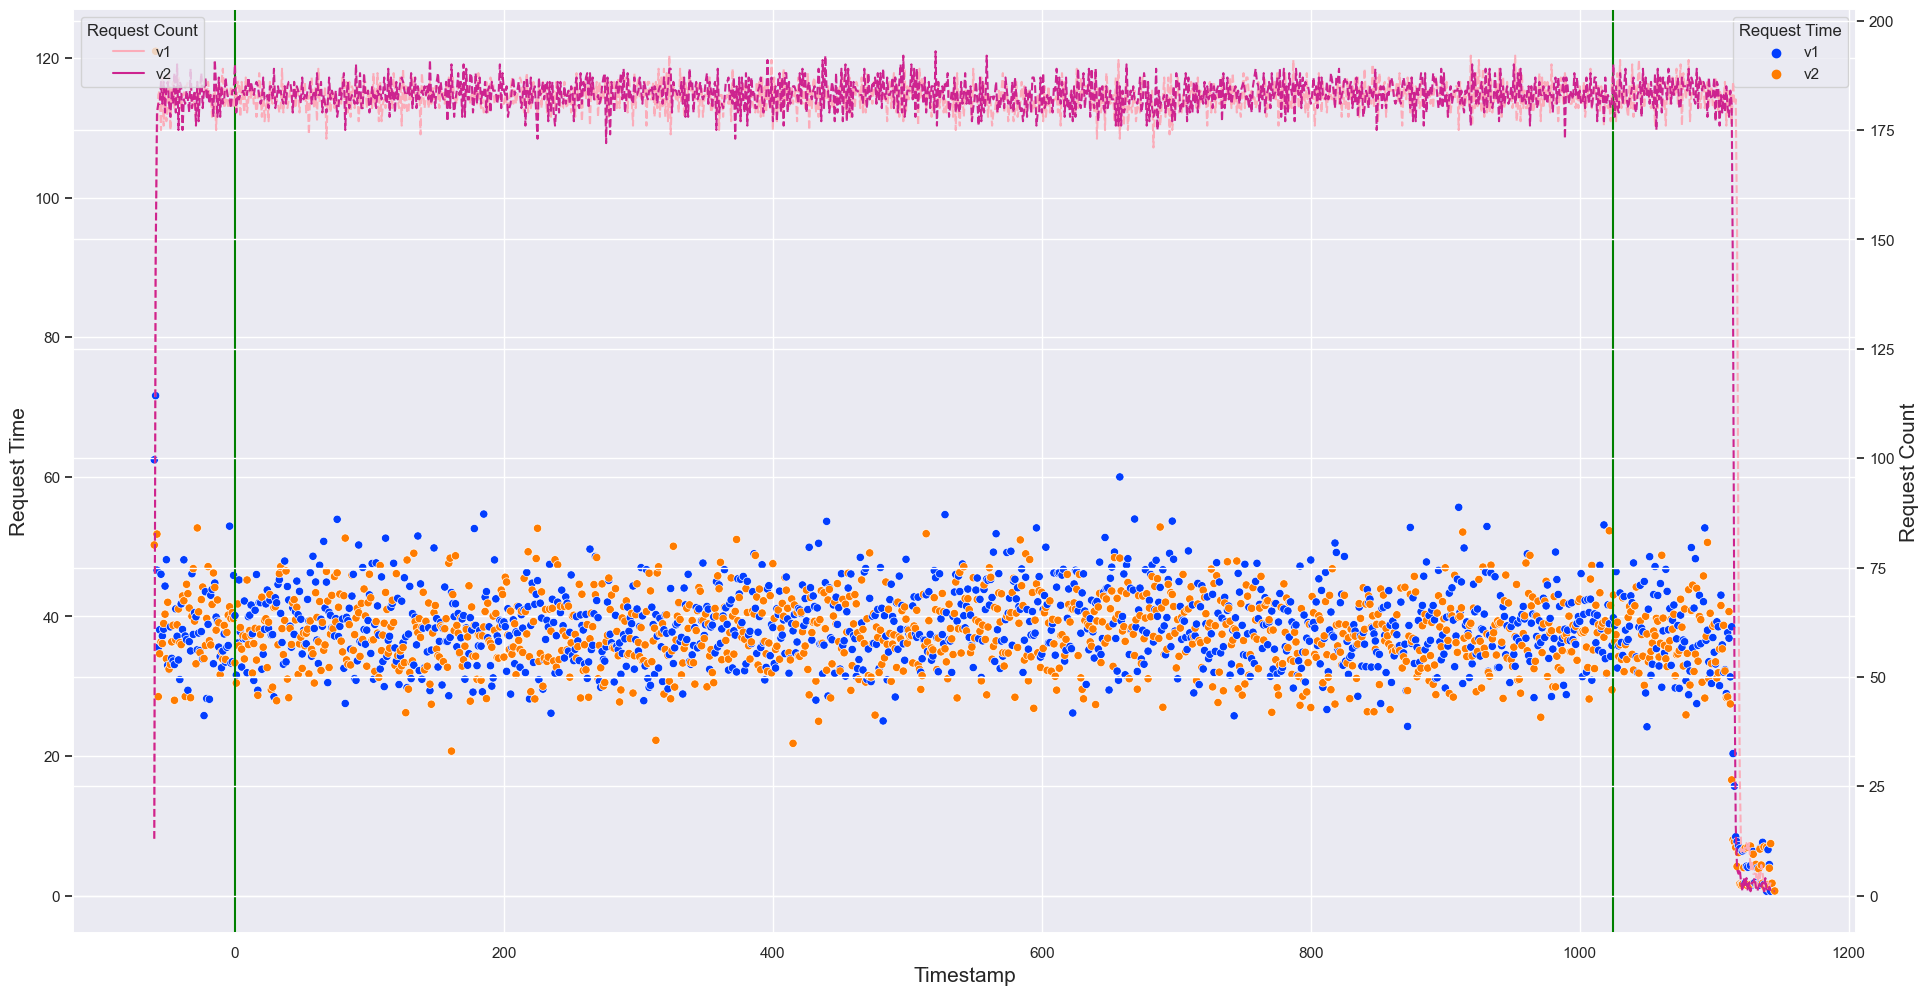

In [261]:
plot_df = df_req_durations.groupby(['timestamp', 'version'])\
  .agg(
    count=('status', 'count'),
    request_duration_median=('metric_value', 'median')
  ).reset_index()

# plot
paletteTime = sns.color_palette("bright", 2)
paletteCount = sns.color_palette("RdPu", 2)

sns.set(rc={'figure.figsize':(23,12)})
g = sns.scatterplot(data = plot_df, x='timestamp', y='request_duration_median', hue='version', palette=paletteTime)
g.axvline(maxCutoffTs, color = "green")
g.axvline(0, color = "green")
g.set_xlabel("Timestamp", fontsize = 15)
g.set_ylabel("Request Time", fontsize = 15)
# g.set_ylim([0, 8500])
g.legend(title="Request Time")
ax2 = g.twinx()
ax2.set_ylabel("Request Count", fontsize = 15)
#ax2.set_ylim([0, 2000])
g2 = sns.lineplot(data = plot_df, x='timestamp', y='count', hue='version', ax=ax2, palette=paletteCount, linestyle="--")
g2.legend(title="Request Count", loc = 'upper left')
g.figure.savefig(f"{benchmarkName}-all-requests.pdf")

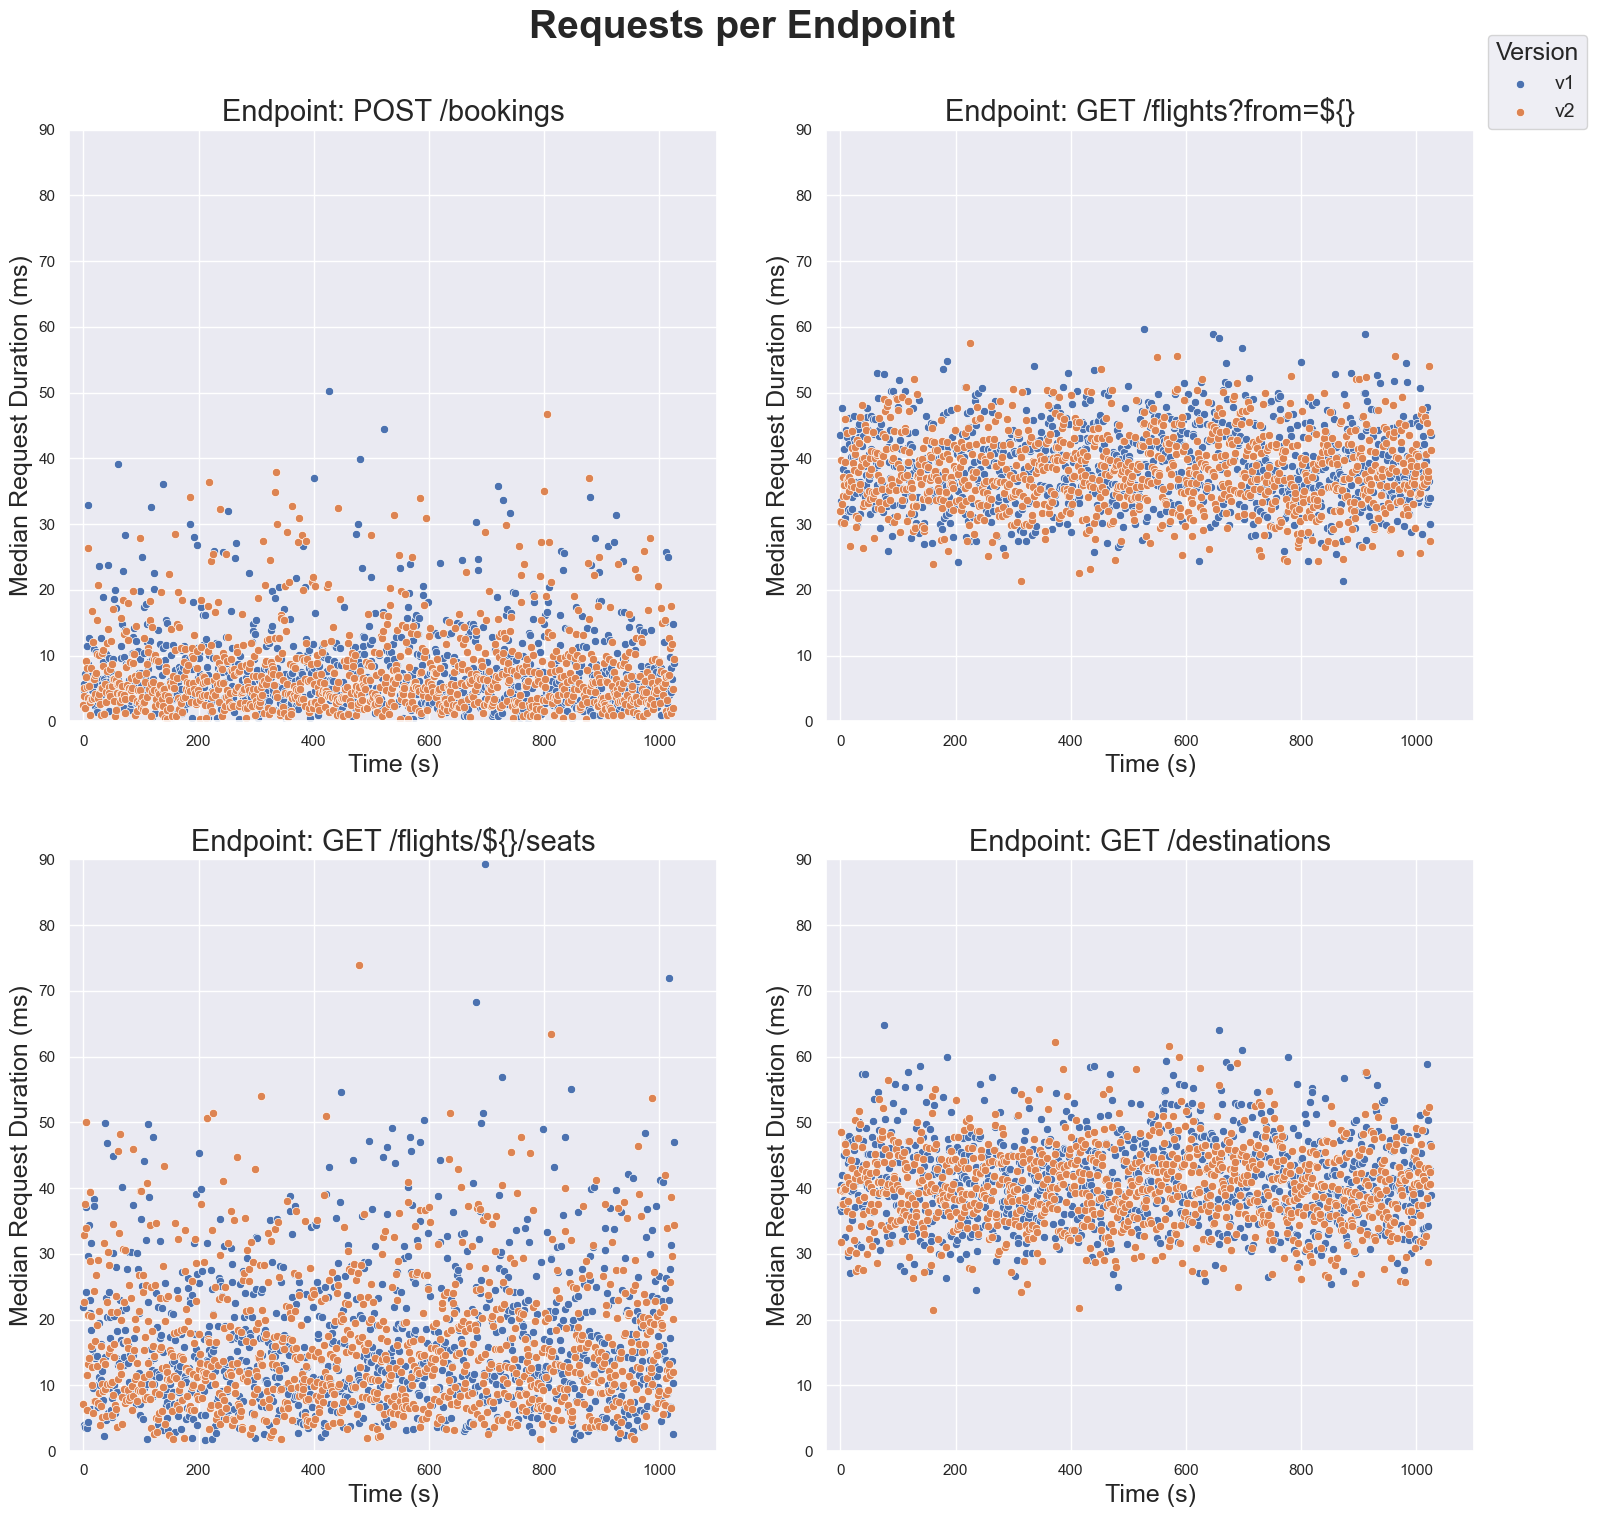

In [395]:
# Requests per Endpoint
plot_df2 = df_filtered\
  .groupby(['timestamp', 'endpoint', 'version'])\
  .agg(request_duration_median=('metric_value', 'median'))\
  .reset_index()


fig = plt.figure(figsize=(15,15))
fig.subplots(2, 2)
fig.suptitle("Requests per Endpoint", fontsize=28, y=1.01, fontweight="bold")

allEndpoints = plot_df2['endpoint'].unique()
allEndpoints.sort()
allEndpoints = allEndpoints.tolist()
lines = []
labels = []

colorPalette = sns.color_palette()

xlimMax = math.ceil(plot_df2['timestamp'].max() / 100) * 100
ylimMax = math.ceil(plot_df2['request_duration_median'].max() / 10) * 10


for ax in fig.axes:
    epName = allEndpoints.pop()
    tmpData = plot_df2[plot_df2['endpoint'] == epName]
    sns.scatterplot(ax=ax, data=tmpData[tmpData["version"] == "v1"], x="timestamp", y="request_duration_median", color=colorPalette[0], label="v1")
    sns.scatterplot(ax=ax, data=tmpData[tmpData["version"] == "v2"], x="timestamp", y="request_duration_median", color=colorPalette[1], label="v2")
    ax.set_title(f"Endpoint: {epName}", fontsize=21)
    ax.set_xlabel("Time (s)", fontsize=18)
    ax.set_xlim(-25, xlimMax)
    ax.set_ylabel("Median Request Duration (ms)", fontsize=18)
    ax.set_ylim(0, ylimMax)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)

fig.tight_layout(h_pad=3, w_pad=3)
legend = fig.legend(lines, labels, title="Version", loc = "upper right", bbox_to_anchor=(1.07, 1), fontsize=14)
legend.get_title().set_fontsize(18)
fig.savefig(f"{benchmarkName}-requests-by-endpoint.pdf", bbox_inches='tight', pad_inches=0.1)

In [313]:
def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
  allRuntimes1 = perfRuntimes1['metric_value'].to_numpy()
  allRuntimes2 = perfRuntimes2['metric_value'].to_numpy()
  numberOfSamples = 10000
  # if both list differ in size, we use the smaller one as our draw-size
  # this way we draw less values than the larger list includes
  measurementsCount = min(allRuntimes1.shape[0], allRuntimes2.shape[0])
  currentMeasurementIndexes1 = rng.choice(allRuntimes1.shape[0], size=(measurementsCount, numberOfSamples))
  currentMeasurementIndexes2 = rng.choice(allRuntimes2.shape[0], size=(measurementsCount, numberOfSamples))

  # Bulk selection
  tmp1 = allRuntimes1[currentMeasurementIndexes1]
  tmp1 = np.stack(tmp1, axis=1)
  tmp2 = allRuntimes2[currentMeasurementIndexes2]
  tmp2 = np.stack(tmp2, axis=1)

  # Get median for both lists
  med1 = np.median(tmp1, axis=1)
  med2 = np.median(tmp2, axis=1)
  R = med2/med1
  R.sort()

  CIsmall = 1 # 99% confidence interval
  small = int((numberOfSamples * CIsmall) / 100 / 2)
  if small == 0: small = 1
  minSmall = R[small-1]
  minSmall = (minSmall - 1) * 100
  maxSmall = R[numberOfSamples-small-1]
  maxSmall = (maxSmall - 1) * 100
  instability = maxSmall - minSmall
  refData = (R-1) * 100
  return refData, minSmall, maxSmall, instability

In [258]:
def compareVersionsForEndpoint(epName: str):
  runtimes1 = df_filtered[(df_filtered['version'] == 'v1') & (df_filtered['endpoint'] == epName)]
  runtimes2 = df_filtered[(df_filtered['version'] == 'v2') & (df_filtered['endpoint'] == epName)]
  # print(f"v1={runtimes1.shape[0]} and v2={runtimes2.shape[0]} values are bootstrapped...")
  median1 = runtimes1['metric_value'].median()
  median2 = runtimes2['metric_value'].median()
  change = ((median2/median1) - 1) * 100
  pvalue = ttest_ind(runtimes1['metric_value'], runtimes2['metric_value'], equal_var=False).pvalue
  refData, minci, maxci, instability = bootstrap(runtimes1, runtimes2)
  assert maxci >= change
  assert change >= minci
  print(f"[{epName}] performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%) (p={pvalue:.6f})")
  return {
    'endpoint': epName,
    'change': change,
    'minci': minci,
    'maxci': maxci,
    'refData': refData
  }


bootstrapResults = []
endpointNames = df_filtered['endpoint'].unique()
endpointNames.sort()
for epName in endpointNames:
  bootstrapResults.append(compareVersionsForEndpoint(epName))

bootstrapResults_df = pd.DataFrame(bootstrapResults)
bootstrapResults_df

[GET /destinations] performance change: -2.27% [-3.43 - -1.13] (2.30%) (p=0.000000)
[GET /flights/${}/seats] performance change: -4.94% [-10.91 - 2.54] (13.45%) (p=0.185206)
[GET /flights?from=${}] performance change: -2.27% [-3.43 - -1.17] (2.26%) (p=0.000000)
[POST /bookings] performance change: -1.72% [-11.80 - 7.29] (19.10%) (p=0.626582)


,endpoint,change,minci,maxci,refData
0,GET /destinations,-2.273568,-3.426452,-1.128197,"[-3.9250107647974652, -3.864958378231287, -3.7..."
1,GET /flights/${}/seats,-4.939628,-10.914246,2.536971,"[-13.615932484908688, -13.30532059469649, -13...."
2,GET /flights?from=${},-2.268258,-3.430487,-1.170503,"[-3.916833464777225, -3.873402244319313, -3.81..."
3,POST /bookings,-1.719085,-11.804396,7.292667,"[-15.849576857638613, -15.553501497219358, -15..."


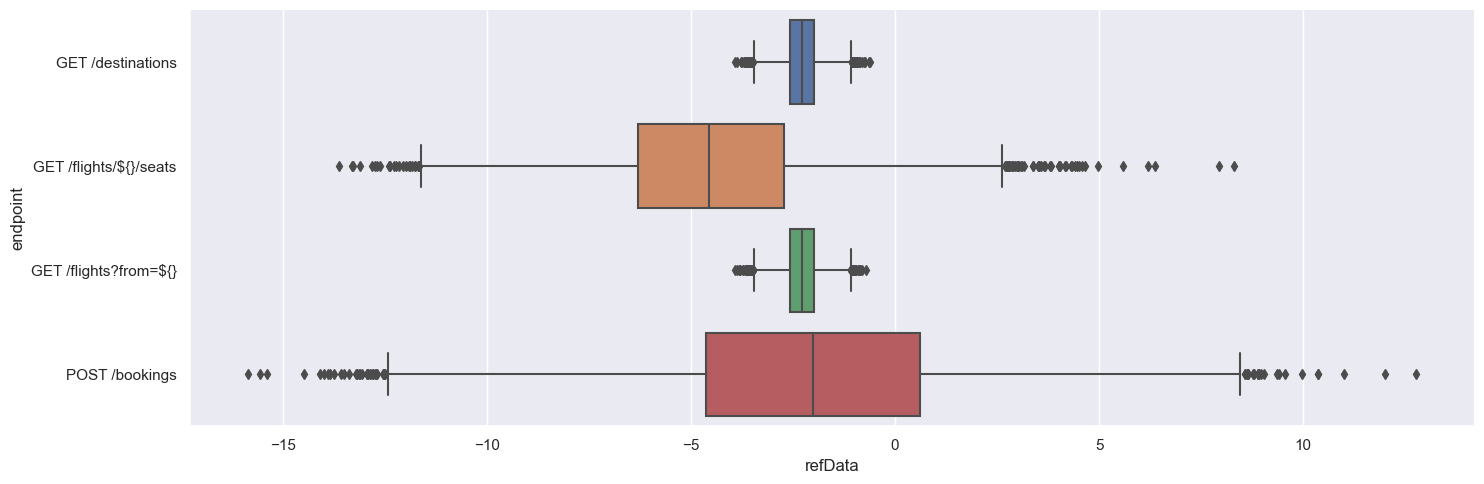

In [259]:
boxPlotDf = bootstrapResults_df.explode('refData')
g = sns.catplot(data=boxPlotDf, x="refData", y="endpoint", kind="box", aspect=3)
g.savefig(f"{benchmarkName}-perf-change.pdf")